<a href="https://colab.research.google.com/github/raul-rufato/smt/blob/newsmt/tutorial/SMT_MixedInteger_application.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with an additive noise term
</b></div>

Andrés F. LOPEZ-LOPERA ONERA/DTIS/M2CI - 

May 2023 - version 2.0

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link: https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

**Reference paper:** https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

**Preprint:** https://www.researchgate.net/profile/Mohamed_Amine_Bouhlel/publication/331976718_A_Python_surrogate_modeling_framework_with_derivatives/links/5cc3cebd299bf12097829631/A-Python-surrogate-modeling-framework-with-derivatives.pdf

Cite us:

M.-A. Bouhlel, J. T. Hwang, N. Bartoli, R. Lafage, J. Morlier, J .R.R.A Martins (2019), A Python surrogate modeling framework with derivatives, Advances in Engineering Software, 102662


# 1. Problem statement

In this notebook, we focus on surrogate Kriging models accouting for a noise term:

$$ y(\mathbf{x}_i) = f(\mathbf{x}_i) + \varepsilon_i, \quad i = 1, \ldots, n,$$

with $\mathbf{x} \in \mathbb{R}^d$, $y \in \mathbb{R}$. Note that $f$ is a (latent) noise-free function and that $\varepsilon_1, \ldots, \varepsilon_n$ are additive noises.

For Kriging purposes, we assume that the latent function $f$ is GP-distributed, i.e. $f \sim \mathcal{GP}(\mu, k)$, and that $\varepsilon_1, \ldots, \varepsilon_n \sim \mathcal{N}(0, \Omega)$ are additive Gaussian noises. For the latter, we assume that they are mutually independent and independent of $f$. This means that the covariance matrix $\Omega$ is given by:
$$\Omega = \begin{bmatrix} \tau_1^2 & \ldots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \ldots & \tau_n^2 \end{bmatrix},$$
with noise variances $\tau_1^2, \ldots, \tau_n^2 \in \mathbb{R}^+$. Then, due to the linearity, $y$ is also GP-distributed. 

Two cases will be considered in the following.

- **Homoscedastic (default) case:** the noise variances are considered to be equal, i.e.: $\tau^2 = \tau_1^2 = \cdots = \tau_n^2$. The value of $\tau^2$ can be estimated via maximum likelihood.
- **Heterocedastic case:** the noise variances vary across the observations, i.e.: $\tau_1^2 \ne \cdots \ne \tau_n^2$. Those variances can only be estimated if repetitions of observations are given. Developments here are based on pointwise sensible estimates [1] and on the implementations in [2].

**References**

[1] Bruce Ankenman, Barry L. Nelson and Jeremy Staum (2010). "Stochastic Kriging for Simulation Metamodeling." Operations Research. Vol. 58, No. 2 , pp. 371-382   
[2] Olivier Roustant, David Ginsbourger and Yves Deville (2012). "DiceKriging, DiceOptim: Two R Packages for the analysis of computer experiments by kriging-based metamodeling and optimization." Journal of Statistical Software, Vol. 51, No. 1, pp. 1-55.

# 2. Homoscedastic Kriging example

To account for an homoscedastic noise term, you can control two main parameters:

- ``noise0``: the initial noise variance. By default, ``noise0 = 0``.
- ``eval_noise``: a flag indicator to estimate the noise variance. By default, ``eval_noise = False``.

<div class="alert alert-info fade in" id="d110">
<p>Remark: by default, no noise is considered in the database.</p>
</div>

## Example 2.1: model comparisons
Next, we test the performance of different Kriging-based models under noise-free and noisy considerations. For the noisy case, we either manually fix or estimate the noise variance parameter via maximum likelihood.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# defining the training data
xt = np.array([0.0, 1.0, 2.0, 2.5, 4.0])
yt = np.array([0.0, 1.0, 1.5, 1.1, 1.0])

# defining the models
sm_noise_free = KRG() # noise-free Kriging model
sm_noise_fixed = KRG(noise0=[1e-1]) # noisy Kriging model with fixed variance
sm_noise_estim = KRG(noise0=[1e-1],  noise_bounds=[1e-2, 1000.0], eval_noise=True) # noisy Kriging model with estimated variance

# training the models
sm_noise_free.set_training_values(xt, yt)
sm_noise_free.train()

sm_noise_fixed.set_training_values(xt, yt)
sm_noise_fixed.train()

sm_noise_estim.set_training_values(xt, yt)
sm_noise_estim.train()



# predictions
x = np.linspace(0, 4, 100).reshape(-1, 1)

y_noise_free = sm_noise_free.predict_values(x) # predictive mean
var_noise_free = sm_noise_free.predict_variances(x) # predictive variance

y_noise_fixed = sm_noise_fixed.predict_values(x) # predictive mean
var_noise_fixed = sm_noise_fixed.predict_variances(x) # predictive variance

y_noise_estim = sm_noise_estim.predict_values(x) # predictive mean
var_noise_estim = sm_noise_estim.predict_variances(x) # predictive variance



print('optimal parameters for noise free', sm_noise_free.optimal_theta)
print('optimal parameters for noise fixed ', sm_noise_fixed.optimal_theta)
print('optimal parameters for noise estimated', sm_noise_estim.optimal_theta)

var_error_free = np.linalg.norm(sm_noise_free.predict_variances(xt)) 
print('Var free noise (must be close to 0) ',var_error_free)
var_error_fixed = np.linalg.norm(sm_noise_fixed.predict_variances(xt)) 
print('Var fixed noise (must be =/ 0) ',var_error_fixed)
var_error_estim = np.linalg.norm(sm_noise_estim.predict_variances(xt)) 
print('Var estimated noise (must be =/ 0) ',var_error_estim)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 5
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1612632
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 5
   
___________________________________________________________________________
   
 Training
   
   Training ...


/stck/psaves/smt/smt/surrogate_models/krg_based.py:2183: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(


   Training - done. Time (sec):  0.1230059
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 5
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2234218
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0028925
   
   Prediction time/pt. (sec) :  0.0000289
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0026383
   
   Prediction time/pt. (sec) :  0.0000264
   
________________________________________________________________

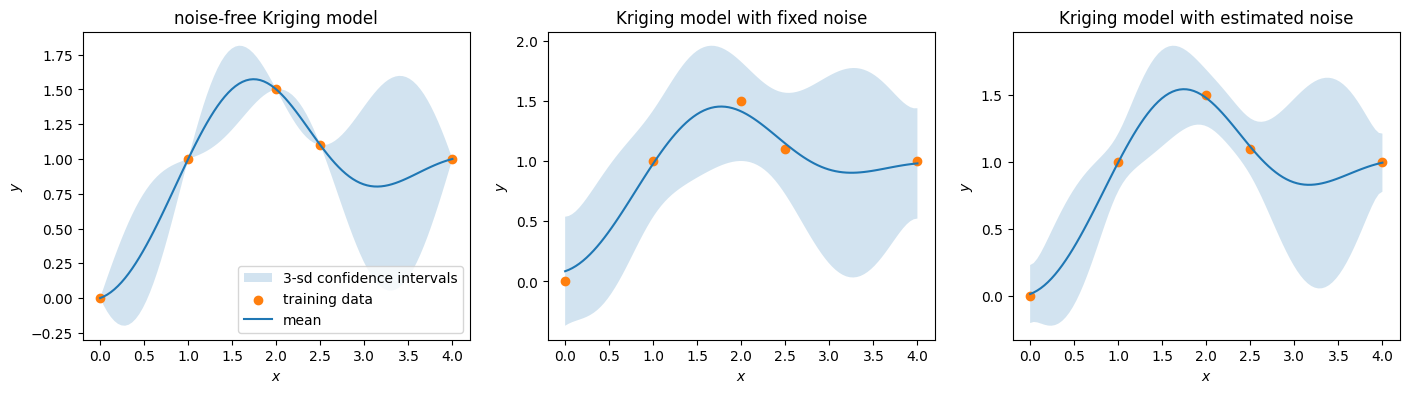

In [2]:
# plotting predictions +- 3 std confidence intervals
plt.rcParams['figure.figsize'] = [17, 4]
fig, axes = plt.subplots(1, 3)

axes[0].fill_between(np.ravel(x),
                     np.ravel(y_noise_free-3*np.sqrt(var_noise_free)),
                     np.ravel(y_noise_free+3*np.sqrt(var_noise_free)),
                     alpha=0.2, label='3-sd confidence intervals')
axes[0].scatter(xt, yt, label="training data")
axes[0].plot(x, y_noise_free, label='mean')
axes[0].set_title('noise-free Kriging model')
axes[0].legend(loc=0)
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$')

axes[1].fill_between(np.ravel(x),
                     np.ravel(y_noise_fixed-3*np.sqrt(var_noise_fixed)),
                     np.ravel(y_noise_fixed+3*np.sqrt(var_noise_fixed)),
                     alpha=0.2, label='3-sd confidence intervals')
axes[1].scatter(xt, yt, label="training data")
axes[1].plot(x, y_noise_fixed, label='mean')
axes[1].set_title('Kriging model with fixed noise')
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')

axes[2].fill_between(np.ravel(x),
                     np.ravel(y_noise_estim-3*np.sqrt(var_noise_estim)),
                     np.ravel(y_noise_estim+3*np.sqrt(var_noise_estim)),
                     alpha=0.2, label='3-sd confidence intervals')
axes[2].scatter(xt, yt, label="training data")
axes[2].plot(x, y_noise_estim, label='mean')
axes[2].set_title('Kriging model with estimated noise')
axes[2].set_xlabel(r'$x$')
axes[2].set_ylabel(r'$y$')
plt.show()

## Example 2.2: noisy observations

We now consider an example with noisy observations. In that case, a noise term is mandatory since we are not interested in the interpolation of data. By setting ``eval_noise = True``, then the noise variance is estimated via maximum likelihood. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# defining the toy example
def target_fun(x):
    return np.cos(5*x)

nobs = 50 # number of obsertvations
np.random.seed(0) # a seed for reproducibility
xt = np.random.uniform(size=nobs) # design points
y_free_noise = target_fun(xt) # noise-free observations

# adding a random noise to observations
yt = target_fun(xt) + np.random.normal(scale=0.05, size=nobs)

# training the model
sm = KRG(eval_noise=True)
sm.set_training_values(xt, yt)
sm.train()

# predictions
x = np.linspace(0, 1, 100).reshape(-1, 1)
y = sm.predict_values(x) # predictive mean
var = sm.predict_variances(x) # predictive variance

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 50
   
___________________________________________________________________________
   
 Training
   
   Training ...


/stck/psaves/smt/smt/surrogate_models/krg_based.py:2183: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(


   Training - done. Time (sec):  0.2793694
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0111792
   
   Prediction time/pt. (sec) :  0.0001118
   


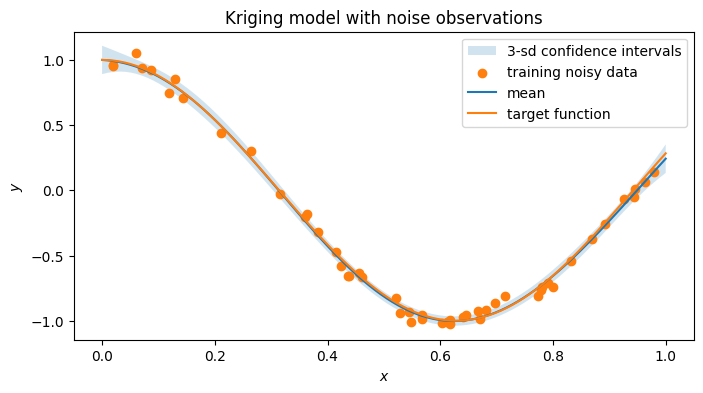

In [4]:
# plotting predictions +- 3 std confidence intervals
plt.rcParams['figure.figsize'] = [8, 4]
plt.fill_between(np.ravel(x),
                 np.ravel(y-3*np.sqrt(var)),
                 np.ravel(y+3*np.sqrt(var)),
                 alpha=0.2, label='3-sd confidence intervals')
plt.scatter(xt, yt, label="training noisy data")
plt.plot(x, y, label='mean')
plt.plot(x, target_fun(x), label='target function')
plt.title('Kriging model with noise observations')
plt.legend(loc=0)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

# 3. Heteroscedastic Kriging example

To account for an heteroscedastic noise term, you only need to set ``use_het_noise == True``. In that case, you need to either provide the noise variances for each observation point (see Example 3.1) or to consider observations with repetitions (see Example 3.2).

## Example 3.1: model with user-predefined noise variances

In some applications, we have access to error bars (noise variances). Those variances ``noise0`` can be passed as a ``list`` or ``np.ndarray`` to enrich the Kriging model.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# defining the training data
xt = np.array([0.0, 1.0, 2.0, 2.5, 4.0])
yt = np.array([0.0, 1.0, 1.5, 1.1, 1.0])

# defining the noise variance per observed data
noise0 = [0.05, 0.001, 0.01, 0.03, 0.05]
# the noise0 must be of the same length than yt. If its length is equal
# to one, the same noise variance is considered everywhere (homoscedastic case)

sm = KRG(noise0=noise0, use_het_noise=True)
sm.set_training_values(xt, yt)
sm.train()

x = np.linspace(0, 4, 100).reshape(-1, 1)
y = sm.predict_values(x)
var = sm.predict_variances(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 5
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1058064
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0027025
   
   Prediction time/pt. (sec) :  0.0000270
   


/stck/psaves/smt/smt/surrogate_models/krg_based.py:2183: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(


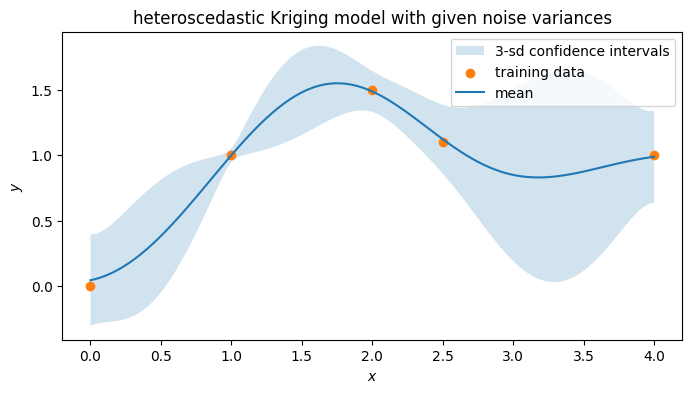

In [6]:
# plotting the resulting Kriging model
plt.fill_between(np.ravel(x), np.ravel(y-3*np.sqrt(var)),
                  np.ravel(y+3*np.sqrt(var)), alpha=0.2,
                  label='3-sd confidence intervals')
plt.scatter(xt, yt, label="training data")
plt.plot(x, y, label='mean')
plt.title('heteroscedastic Kriging model with given noise variances')
plt.legend(loc=0)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## Example 3.2: observations with repetitions

If considering observations with repetitions, the noise variance can be estimated according to [1,2]. In that case, there is no need to define ``noise0`` but you must provide the repetitions.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# defining the training data
xt = np.array([0.0, 1.0, 2.0, 2.5, 4.0])
yt = np.array([0.0, 1.0, 1.5, 1.1, 1.0])

# adding noisy repetitions
xt_full = xt.copy()
yt_full = yt.copy()
for i in range(4):
    xt_full = np.concatenate((xt_full, xt))
    np.random.seed(i)
    yt_full = np.concatenate((yt_full,
                              yt + np.std(yt)*np.random.uniform(size=yt.shape)))

# training the model
sm = KRG(use_het_noise=True, eval_noise=True)
sm.set_training_values(xt_full, yt_full)
sm.train()

# predictions
x = np.linspace(0, 4, 100).reshape(-1, 1)
y = sm.predict_values(x)
var = sm.predict_variances(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 25
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1203332
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0069165
   
   Prediction time/pt. (sec) :  0.0000692
   


/stck/psaves/smt/smt/surrogate_models/krg_based.py:2183: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(


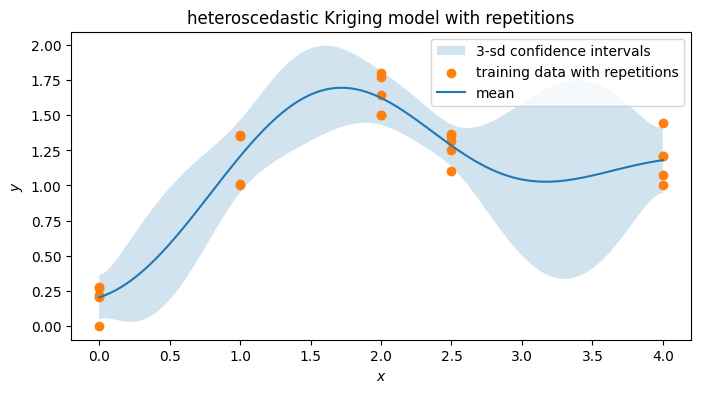

In [8]:
# plotting the resulting Kriging model
plt.fill_between(np.ravel(x), np.ravel(y-3*np.sqrt(var)),
                  np.ravel(y+3*np.sqrt(var)), alpha=0.2,
                  label='3-sd confidence intervals')
plt.scatter(xt_full, yt_full, label="training data with repetitions")
plt.plot(x, y, label='mean')
plt.title('heteroscedastic Kriging model with repetitions')
plt.legend(loc=0)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()